In [1]:
from data_utils import DATA_DIR, load_labels, aug_crossentropy_RI_Dataset, AddGaussianNoise, crossentropy_RI_Dataset
from network_def_crossentropy import CNN, CNN_direct
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms.v2 as tvtf
import numpy as np
import torchinfo

In [2]:
dropout_rate = 0.2
device = "cpu"

In [3]:
valid_labels, _ = load_labels(DATA_DIR + '/valid_labels.json')
cnn_valid_ds = crossentropy_RI_Dataset(valid_labels)

batch_size = 16*2
cnn_valid_dataloader = DataLoader(cnn_valid_ds, num_workers=1, batch_size=batch_size)

In [4]:
test_ds = iter(cnn_valid_ds)

In [5]:
X, y = next(test_ds)

In [6]:
X.shape

torch.Size([1, 380, 540])

In [7]:
train_labels, train_weights = load_labels(DATA_DIR + '/train_labels.json')
cnn_train_ds = crossentropy_RI_Dataset(train_labels)

batch_size = 16*2
wtd_sampler = WeightedRandomSampler(train_weights, len(train_labels), replacement=True)
cnn_train_dataloader = DataLoader(cnn_train_ds, num_workers=1, batch_size=batch_size, sampler=wtd_sampler)

In [9]:
cnn_model = CNN_direct()
# cnn_model.load_state_dict(torch.load('./saved_models/crossentropy_cnn.pt', map_location=torch.device('cpu')))
# cnn_model.eval()

In [10]:
torchinfo.summary(cnn_model, (32, 1, 380, 540))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_direct                               [32, 2]                   --
├─Sequential: 1-1                        [32, 256, 5, 8]           --
│    └─Conv2d: 2-1                       [32, 8, 380, 540]         80
│    └─ReLU: 2-2                         [32, 8, 380, 540]         --
│    └─Conv2d: 2-3                       [32, 8, 380, 540]         584
│    └─ReLU: 2-4                         [32, 8, 380, 540]         --
│    └─MaxPool2d: 2-5                    [32, 8, 190, 270]         --
│    └─Conv2d: 2-6                       [32, 16, 190, 270]        1,168
│    └─ReLU: 2-7                         [32, 16, 190, 270]        --
│    └─Conv2d: 2-8                       [32, 16, 190, 270]        2,320
│    └─ReLU: 2-9                         [32, 16, 190, 270]        --
│    └─MaxPool2d: 2-10                   [32, 16, 95, 135]         --
│    └─Conv2d: 2-11                      [32, 32, 95, 135]         4,640
│    

In [180]:
train_iterator = iter(cnn_train_dataloader)

In [181]:
train_vals = next(train_iterator)
train_input = train_vals[0]
train_target = train_vals[1]
print(train_input.shape)
print(train_target.shape)

torch.Size([32, 1, 380, 540])
torch.Size([32])


In [154]:
test_iterator = iter(cnn_valid_dataloader)

In [172]:
test_vals = next(test_iterator)
test_input = test_vals[0]
test_target = test_vals[1]
print(test_input.shape)
print(test_target.shape)

torch.Size([32, 1, 380, 540])
torch.Size([32])


In [38]:
with torch.no_grad():
    test_output = cnn_model(train_input_reshape)

In [39]:
test_output.shape

torch.Size([16, 2])

In [40]:
test_output

tensor([[0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959],
        [0.5041, 0.4959]])

In [175]:
test_target

tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [176]:
test_output

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [166]:
test_input.mean()

tensor(0.0226)

In [17]:
train_labels, train_weights = load_labels(DATA_DIR + '/train_labels.json')
rotate_transform = tvtf.RandomRotation(50)
noise_transform = AddGaussianNoise(std=0.5)
translate_transform = tvtf.RandomAffine(0, translate=(0.1, 0.1))
transform_list = [
    rotate_transform,
    rotate_transform,
    translate_transform,
    translate_transform,
    noise_transform,
    noise_transform,
    noise_transform,
]
cnn_train_ds = aug_crossentropy_RI_Dataset(train_labels)

num_batches = 32
batch_size = 16
wtd_sampler = WeightedRandomSampler(train_weights, num_batches*batch_size, replacement=True)
cnn_train_dataloader = DataLoader(cnn_train_ds, num_workers=1, batch_size=batch_size, sampler=wtd_sampler)

In [18]:
train_iter = iter(cnn_train_dataloader)

In [19]:
train_input, train_target = next(train_iter)

In [24]:
train_target.shape

torch.Size([16, 1])

In [12]:
train_target = train_target.view(-1)

In [21]:
train_input.shape

torch.Size([16, 1, 1, 380, 540])

In [22]:
train_input_reshape = train_input.view(-1, 1, 380, 540)

In [23]:
train_input_reshape.shape

torch.Size([16, 1, 380, 540])

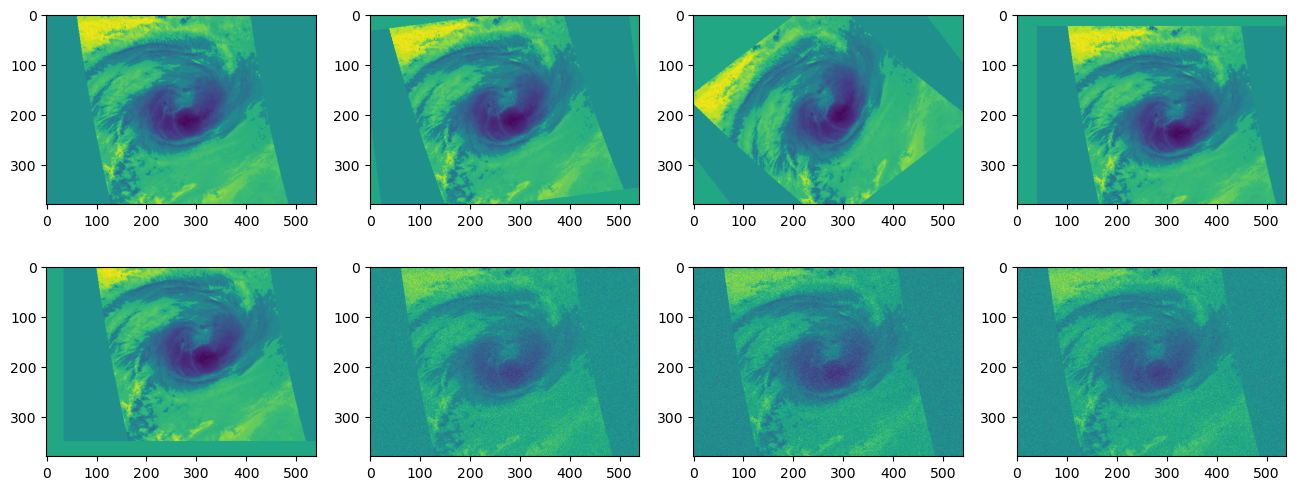

In [54]:
F, axs = plt.subplots(2, 4, figsize=(16, 6))
for i, ax in enumerate(np.ravel(axs)):
    ax.imshow(train_input[0, i, 0, ...])

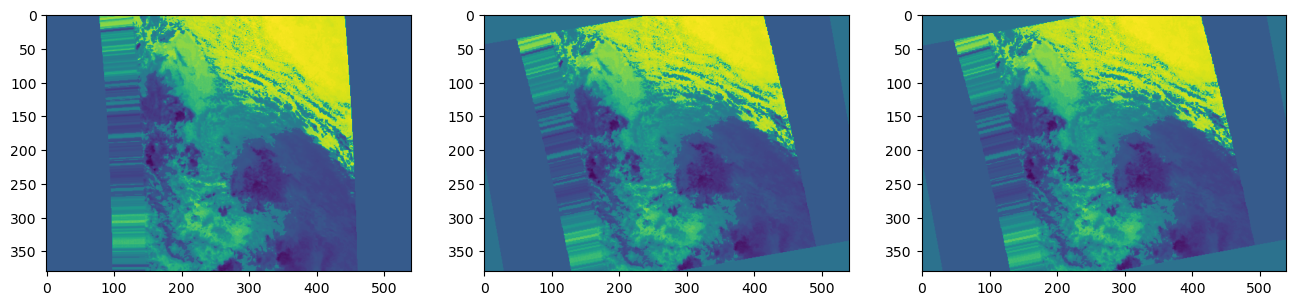

In [34]:
F, ax = plt.subplots(1, 3, figsize=(16, 6))
for i in range(3):
    ax[i].imshow(train_input_reshape[i, 0, ...])